In [15]:
# import the necessary packages
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import numpy as np
import colorsys
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt

In [13]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
ROOT_DIR = 'D:\\Study\\DataScience\\OpenCV\\OCR\\mrcnn'

In [4]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
WEIGHTS_DIR = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [5]:
# load the class label names from disk, one label per line
CLASS_NAMES = open('D:\\Study\\DataScience\\OpenCV\\OCR\\mrcnn\\coco_labels.txt').read().strip().split("\n")

In [6]:
# generate random (but visually distinct) colors for each class label
# (thanks to Matterport Mask R-CNN for the method!)
hsv = [(i / len(CLASS_NAMES), 1, 1.0) for i in range(len(CLASS_NAMES))]
COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.seed(42)
random.shuffle(COLORS)

In [7]:
class SimpleConfig(Config):
    # give the configuration a recognizable name
    NAME = "coco_inference"
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # number of classes (we would normally add +1 for the background
    # but the background class is *already* included in the class
    # names)
    NUM_CLASSES = len(CLASS_NAMES)

In [8]:
# initialize the inference configuration
config = SimpleConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [23]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(WEIGHTS_DIR, by_name=True)

In [27]:
image = cv2.imread('D:\\Study\\DataScience\\OpenCV\\OCR\\mrcnn\\images\\people.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=512)
# perform a forward pass of the network to obtain the results
print("[INFO] making predictions with MaMask R-CNN...")
r = model.detect([image], verbose=1)[0]

[INFO] making predictions with MaMask R-CNN...
Processing 1 images
image                    shape: (491, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [28]:
# loop over of the detected object's bounding boxes and masks
for i in range(0, r["rois"].shape[0]):
    # extract the class ID and mask for the current detection, then
    # grab the color to visualize the mask (in BGR format)
    classID = r["class_ids"][i]
    mask = r["masks"][:, :, i]
    color = COLORS[classID][::-1]
    # visualize the pixel-wise mask of the object
    image = visualize.apply_mask(image, mask, color, alpha=0.5)

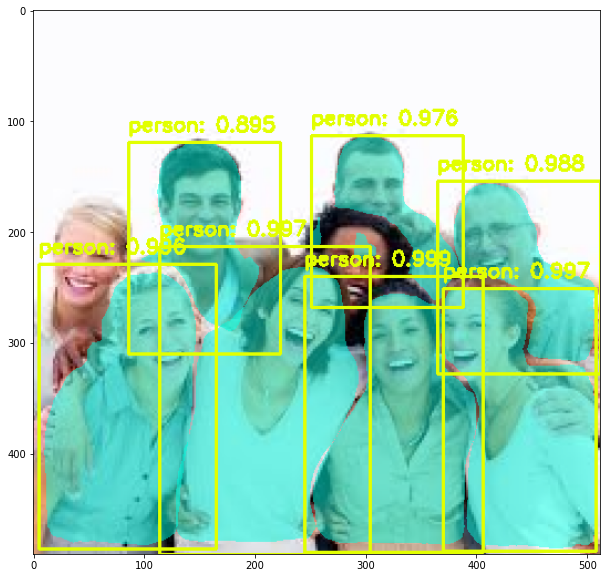

In [30]:
# convert the image back to BGR so we can use OpenCV's drawing
# functions

image = imutils.resize(image, width=512)
# loop over the predicted scores and class labels
for i in range(0, len(r["scores"])):
    # extract the bounding box information, class ID, label, predicted
    # probability, and visualization color
    (startY, startX, endY, endX) = r["rois"][i]
    classID = r["class_ids"][i]
    label = CLASS_NAMES[classID]
    score = r["scores"][i]
    color = [int(c) for c in np.array(COLORS[classID]) * 255]
    # draw the bounding box, class label, and score of the object
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    text = "{}: {:.3f}".format(label, score)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    

# show the output image
plt.figure(figsize = (12,10))
plt.imshow(image)
